In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output
import numpy as np

In [24]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver('local')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    print('die')

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [25]:
num_embeddings=256
embedding_dim=256

In [26]:
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.layers import Conv2D, Add

@register_keras_serializable(package="Custom")
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.f = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.g = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.h = Conv2D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x):
        f = self.f(x)  # (B, H, W, C//8)
        g = self.g(x)
        h = self.h(x)  # (B, H, W, C)

        shape_f = tf.shape(f)
        B, H, W = shape_f[0], shape_f[1], shape_f[2]

        f_flat = tf.reshape(f, [B, H * W, self.filters // 8])
        g_flat = tf.reshape(g, [B, H * W, self.filters // 8])
        h_flat = tf.reshape(h, [B, H * W, self.filters])

        beta = tf.nn.softmax(tf.matmul(f_flat, g_flat, transpose_b=True), axis=-1)  # (B, N, N)

        o = tf.matmul(beta, h_flat)  # (B, N, C)
        o = tf.reshape(o, [B, H, W, self.filters])

        return Add()([x, o])  # Residual connection

    def get_config(self):
        config = super().get_config()
        # If you have custom arguments in __init__, add them here
        return config


In [27]:
with strategy.scope():
    captions = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_78/Captions (1).npy')
    tokens_seq = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_78/Tokens_seq (1).npy').astype(np.int32)
    encoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_encoder.keras',custom_objects={'SelfAttention': SelfAttention})
    decoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_decoder.keras',custom_objects={'SelfAttention': SelfAttention})
    codebook = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_codebook.npy')

In [28]:
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 18500
sequence_length = 85

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)


vectorizer.adapt(captions)
text_vect = tf.cast(vectorizer(captions),tf.int32)

In [29]:
start_tokens = tf.cast(tf.fill([len(text_vect), 1], 256),tf.int32)
decoder_tokens = tf.concat([start_tokens, tokens_seq], axis=1)

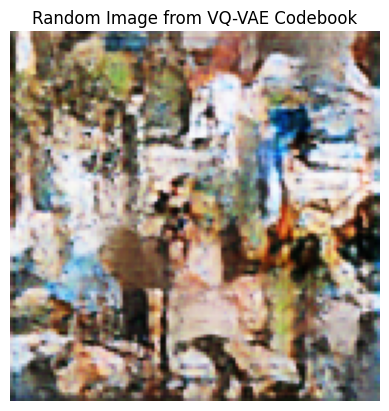

In [30]:
random_indices = tf.random.uniform(shape=(1, 16, 16), minval=100, maxval=254, dtype=tf.int32)
flat_indices = tf.reshape(random_indices, [-1])
quantized_vectors = tf.gather(codebook, flat_indices)
quantized_vectors = tf.reshape(quantized_vectors, (1, 16, 16
                                                   , embedding_dim))

# Decode to image
generated_image = decoder(quantized_vectors)
# Display
import matplotlib.pyplot as plt
plt.imshow(generated_image[0].numpy())
plt.axis('off')
plt.title('Random Image from VQ-VAE Codebook')
plt.show()

In [31]:
BATCH_SIZE = 512

transformer_dataset = (
    tf.data.Dataset.from_tensor_slices((
        (tf.convert_to_tensor(text_vect, dtype=tf.int32),
         tf.convert_to_tensor(decoder_tokens[:, :-1], dtype=tf.int32)),
        tf.convert_to_tensor(decoder_tokens[:, 1:], dtype=tf.int32)
    ))
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)
sample_dataset = transformer_dataset.take(20)

total_length = int(len(text_vect)/BATCH_SIZE)
train_size = 0.7
train_dataset = transformer_dataset.take(int(total_length*train_size))
val_dataset = transformer_dataset.skip(int(total_length*train_size))

# Distribute the dataset after taking sample
sample_dataset = strategy.experimental_distribute_dataset(sample_dataset)
train_dataset = strategy.experimental_distribute_dataset(train_dataset)
val_dataset = strategy.experimental_distribute_dataset(val_dataset)

In [32]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-5)
        self.dropout_1 = layers.Dropout(0.1)

    def call(self, inputs, mask=None):
        # Convert mask to boolean with shape (batch, 1, seq_len)
        if mask is not None:
            mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)

        attention_output = self.attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=mask
        )
        attention_output = self.dropout_1(attention_output)
        proj_input = self.layernorm_1(inputs + attention_output)

        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [33]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=int(embed_dim/num_heads))
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.1)
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-5)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-5)

    # def get_causal_attention_mask(self, inputs):
    #     seq_len = tf.shape(inputs)[1]
    #     causal_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len), dtype=tf.bool), -1, 0)
    #     return causal_mask[tf.newaxis, :, :]  # (1, seq_len, seq_len)

    def call(self, inputs, encoder_outputs, mask=None):
        # Padding mask: (batch_size, 1, seq_len)
        # if mask is not None:
        #     padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)
        # else:
        #     padding_mask = None

        # # Causal mask: (1, seq_len, seq_len)
        # causal_mask = self.get_causal_attention_mask(inputs)

        # # Combine masks for self-attention
        # if padding_mask is not None:
        #     combined_mask = tf.logical_and(padding_mask, causal_mask)
        # else:
        #     combined_mask = causal_mask

        # Self-attention with combined mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            use_causal_mask=True
        )
        attention_output_1 = self.dropout_1(attention_output_1)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention with padding mask only
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=mask,
            use_causal_mask=False
        )
        attention_output_2 = self.dropout_2(attention_output_2)
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)

        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [34]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, mask_zero = True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim,mask_zero=mask_zero)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,mask_zero=False)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [35]:
with strategy.scope():
    embed_dim = 512
    dense_dim = 2048
    num_heads = 8
    num_blocks = 7
    
    encoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="encoder_inputs")
    decoder_inputs = tf.keras.Input(shape=(None,), dtype="int32", name="decoder_inputs")
    
    # Padding masks
    encoder_mask = tf.keras.layers.Lambda(lambda x: tf.cast(tf.not_equal(x, 0), tf.bool))(encoder_inputs)
    cross_attention_mask = tf.keras.layers.Lambda(lambda x: tf.cast(x[:, tf.newaxis, tf.newaxis, :], tf.bool))(encoder_mask) 
    
    # Embeddings
    encoder_embed = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
    decoder_embed = PositionalEmbedding(256, 257, embed_dim,mask_zero=False)(decoder_inputs)
    
    # Encoder blocks
    x = encoder_embed
    for _ in range(num_blocks):
        x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x, mask=encoder_mask)
    encoder_outputs = x
    
    # Decoder blocks
    x = decoder_embed
    for _ in range(num_blocks):
        x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs, mask=cross_attention_mask)
    
    # Final layers
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = layers.Dropout(0.1)(x)
    decoder_outputs = layers.Dense(256)(x)

    transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [36]:
transformer.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 512) │  9,515,520 │ encoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, None)      │          0 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ positional_embed… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 512) │    262,656 │ decoder_inputs[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 512) │  3,152,384 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, 1,      │          0 │ lambda_2[0][0]    │
│                     │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 512) │  4,204,032 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 512) │  4,204,032 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 512) │  4,204,032 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ lambda_3[0][0]  

 Total params: 61,405,440 (234.24 MB)

 Trainable params: 61,405,440 (234.24 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
start_token = 256
max_output_length = 256

def generate_image_tokens(input_text):
    # Vectorize input text
    tokenized_text = vectorizer([input_text])  # Shape: (1, text_seq_len)

    # Start the decoded sequence with the start token
    decoded_image_tokens = [start_token]

    for i in range(max_output_length):
        # Convert to proper input format
        decoder_input = tf.convert_to_tensor([decoded_image_tokens])

        # Predict next token probabilities
        predictions = (transformer([tokenized_text, decoder_input]))
        

        # Get the token for the current step
        sampled_token_index = np.argmax(predictions[0, -1, :])

        # Append token to sequence
        decoded_image_tokens.append(sampled_token_index)

    # Optionally decode tokens into an image here
    return decoded_image_tokens[1:]

def get_embeddings(indices, codebook):
    flat_indices = tf.reshape(indices, [-1])
    flat_embeddings = tf.nn.embedding_lookup(codebook, flat_indices)

    out_shape = tf.concat([tf.shape(indices), [tf.shape(codebook)[-1]]], axis=0)
    return tf.reshape(flat_embeddings, (-1,16,16,256))

In [38]:
class ImageGeneration(tf.keras.callbacks.Callback):
    def __init__(self, txt):
        super().__init__()
        self.txt = txt
    def on_epoch_end(self,epoch,logs=None):
        if epoch % 100 == 0 and epoch != 0:
            clear_output(wait=True)
            print(f"Epoch:{epoch}")
            print(f"Prompt:{self.txt}")
            tokens = generate_image_tokens(self.txt)
            embedding = get_embeddings(tokens,codebook)
            image = decoder(embedding)
            plt.imshow(image[0])
            plt.show()

In [39]:
with strategy.scope():
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    callback = ImageGeneration("A child is falling off a slide onto colored balloons floating on a pool of water")

In [40]:
with strategy.scope():
    def perplexity(y_true, y_pred):
        loss = loss_fn(y_true, y_pred)
        return tf.exp(tf.reduce_mean(loss))

Epoch:200
Prompt:A child is falling off a slide onto colored balloons floating on a pool of water


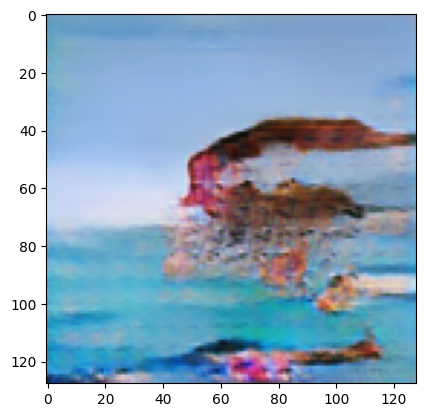

43/43 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - accuracy: 0.4605 - loss: 2.0403 - perplexity: 1.2906 - val_accuracy: 0.0545 - val_loss: 6.9682 - val_perplexity: 2.3897
Epoch 202/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.4616 - loss: 2.0379 - perplexity: 1.2902 - val_accuracy: 0.0548 - val_loss: 6.9418 - val_perplexity: 2.3818
Epoch 203/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.4640 - loss: 2.0247 - perplexity: 1.2881 - val_accuracy: 0.0560 - val_loss: 6.9606 - val_perplexity: 2.3875
Epoch 204/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.4677 - loss: 2.0060 - perplexity: 1.2851 - val_accuracy: 0.0556 - val_loss: 7.0993 - val_perplexity: 2.4292
Epoch 205/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.4743 - loss: 1.9837 - perplexity: 1.2815 - val_accuracy: 0.0558 - val_loss: 7.1258 - val_perplexity: 2.4373
Epoch 206/400
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.4748 - loss: 1.9730 - perplexity: 1.2798 - val_accuracy: 0.05

In [ ]:
with strategy.scope():
    transformer.compile(loss=loss_fn,
                       optimizer=optimizer,
                       metrics=['accuracy',perplexity])
    transformer.fit(train_dataset,epochs=400, callbacks=[callback],validation_data=val_dataset)

In [ ]:
with strategy.scope():
    output_tokens = generate_image_tokens("black dog in grass")
    embedding = get_embeddings(output_tokens,codebook)
    image = decoder(embedding)
    plt.imshow(image[0])
    plt.show()

In [ ]:
print(np.shape(get_embeddings(output_tokens,codebook)))

In [ ]:
print(img[0])

In [ ]:
plt.imshow(img[0])
plt.show()